<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\IT SOLUTION\AppData\Local\Temp\ipykernel_15524\3715433855.py:16: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv("yeast.data", sep='\s+', header=None)
C:\Users\IT SOLUTION\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 1187, number of used features: 6
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\IT SOLUTION\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\IT SOLUTION\AppData\Local\Temp\ipykernel_15524\3715433855.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="mako")


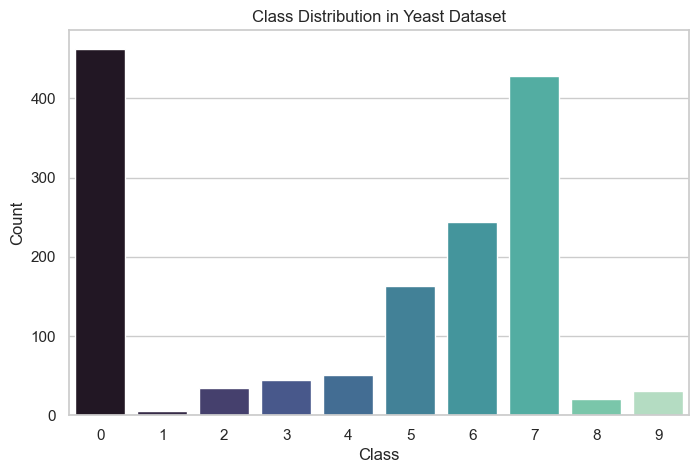

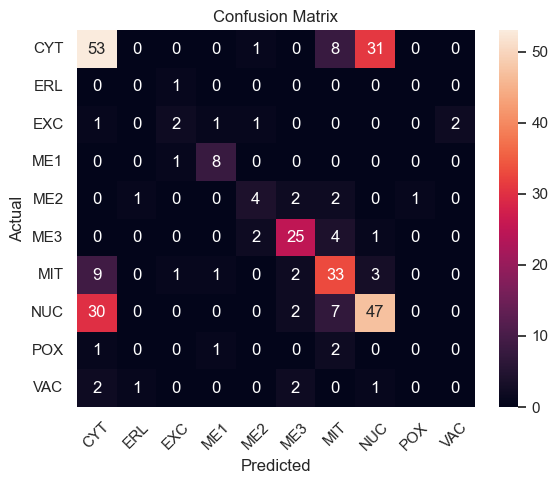

C:\Users\IT SOLUTION\AppData\Local\Temp\ipykernel_15524\3715433855.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feat_names[indices], palette="inferno")


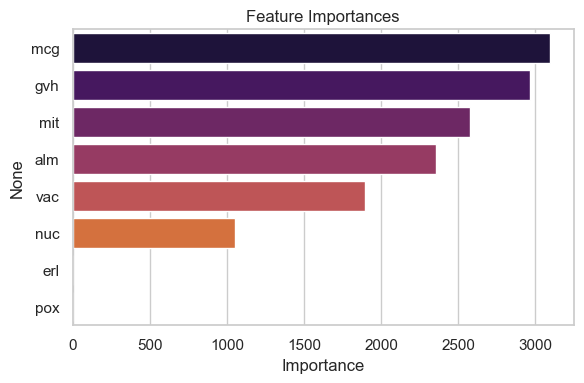

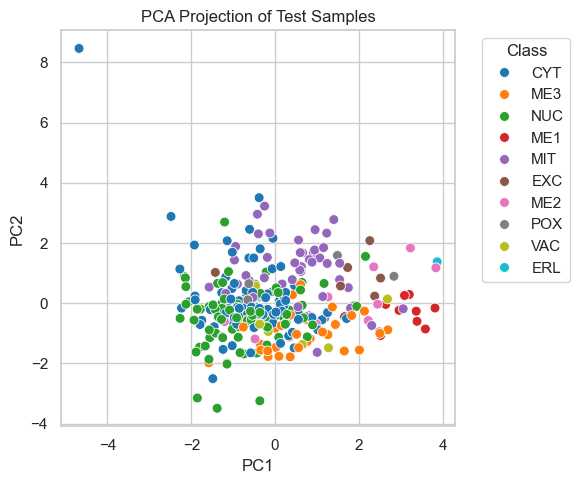

In [5]:
# Yeast Dataset Multi-Class Classification (LightGBM, Class Weights)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import randint, uniform
from sklearn.decomposition import PCA

# 1. Load dataset
df = pd.read_csv("yeast.data", sep='\s+', header=None)
df.columns = ['SequenceName','mcg','gvh','alm','mit','erl','pox','vac','nuc','Class']
df.drop('SequenceName', axis=1, inplace=True)  # drop ID column

# 2. Encode target
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# 3. Features & target
X = df.drop('Class', axis=1)
y = df['Class']

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(zip(np.unique(y_train), class_weights))

# 7. LightGBM classifier with class weights
lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y)),
    class_weight=weight_dict,
    n_jobs=-1,
    random_state=42
)

# 8. Hyperparameter search
param_dist = {
    'n_estimators': randint(200, 800),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 100),
    'colsample_bytree': uniform(0.6, 0.4),
    'subsample': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 2)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 9. Fit model
search.fit(X_train_scaled, y_train)
best_model = search.best_estimator_
print("Best CV accuracy:", search.best_score_)
print("Best params:", search.best_params_)

# 10. Evaluate on test set
y_pred = best_model.predict(X_test_scaled)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# ------------------ Visualizations ------------------

sns.set(style="whitegrid")

# 11. Class distribution
counts = y.value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=counts.index, y=counts.values, palette="mako")
plt.title("Class Distribution in Yeast Dataset")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()

# 12. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", vmax=cm.max(), xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 13. Feature importance
importances = best_model.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(6,4))
sns.barplot(x=importances[indices], y=feat_names[indices], palette="inferno")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 14. PCA 2D projection
Xpca = PCA(n_components=2, random_state=42).fit_transform(X_test_scaled)
plt.figure(figsize=(6,5))
sns.scatterplot(x=Xpca[:,0], y=Xpca[:,1], hue=le.inverse_transform(y_test), palette="tab10", s=50)
plt.title("PCA Projection of Test Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Class", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()
